In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tipo = "FLSPass/DelayVariavel/P0_100/"
base = "../../../../../Simulations/SingleCell/" + tipo
graphicsbase = "../../pdfs/" + tipo
until = 21
users = 51
scheds = 9
from LTEParser import LTEParser
parser = LTEParser()
metrics = parser.parse(base, graphicsbase, scheds, users, until, 100)
from LTEParser import Graphics
graphicWriter = Graphics(graphicsbase, metrics)
metrics

Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_1.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_2.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_3.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_4.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_5.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_6.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_7.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_10_8.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/Dela

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_11.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_12.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_13.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_14.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_15.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_16.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_17.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_1_UE_40_18.gz
	Parsing ...Done
Opening file: ../../../../../Simulation

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_1.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_2.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_3.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_4.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_5.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_6.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_7.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_2_UE_30_8.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/Single

Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_11.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_12.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_13.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_14.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_15.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_16.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_17.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_10_18.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSP

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_1.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_2.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_3.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_4.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_5.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_6.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_7.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_3_UE_50_8.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/Single

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_11.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_12.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_13.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_14.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_15.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_16.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_17.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_4_UE_30_18.gz
	Parsing ...Done
Opening file: ../../../../../Simulation

Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_10_20.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_20_1.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_20_2.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_20_3.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_20_4.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_20_5.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_20_6.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_20_7.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/Del

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_10.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_11.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_12.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_13.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_14.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_15.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_16.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_5_UE_50_17.gz
	Parsing ...Done
Opening file: ../../../../../Simulation

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_30_20.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_40_1.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_40_2.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_40_3.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_40_4.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_40_5.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_40_6.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_6_UE_40_7.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/Singl

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_10.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_11.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_12.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_13.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_14.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_15.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_16.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_20_17.gz
	Parsing ...Done
Opening file: ../../../../../Simulation

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_7_UE_50_20.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_10_1.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_10_2.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_10_3.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_10_4.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_10_5.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_10_6.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_10_7.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/Singl

	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_10.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_11.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_12.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_13.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_14.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_15.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_16.gz
	Parsing ...Done
Opening file: ../../../../../Simulations/SingleCell/FLSPass/DelayVariavel/P0_100/SCHED_8_UE_40_17.gz
	Parsing ...Done
Opening file: ../../../../../Simulation

{'VIDEO': {'GPUT': {1: [{'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0}],
   2: [{'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0}],
   3: [{'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0}],
   4: [{'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0}],
   5: [{'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0}],
   6: [{'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.0}],
   7: [{'MEAN': 0.0, 'CI': 0.0},
    {'MEAN': 0.0, 'CI': 0.

# WEB

In [2]:
kind = "WEB"

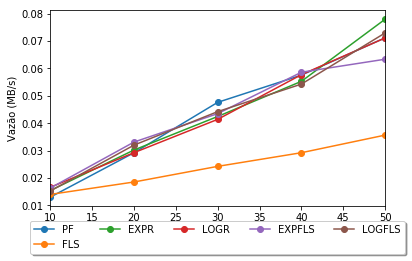

In [3]:
graphicWriter.gputFile(kind, True, True)

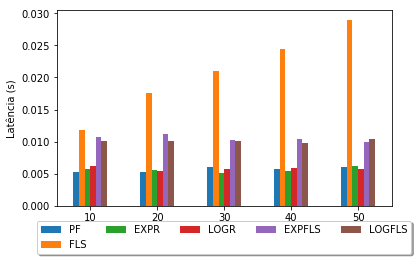

In [4]:
graphicWriter.delayFile(kind, True, True)

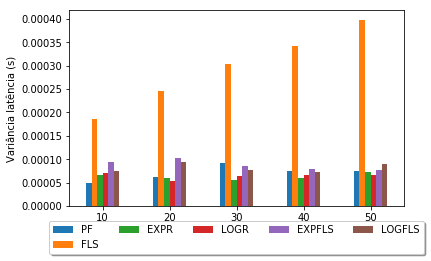

In [5]:
graphicWriter.jitterFile(kind, True, True)

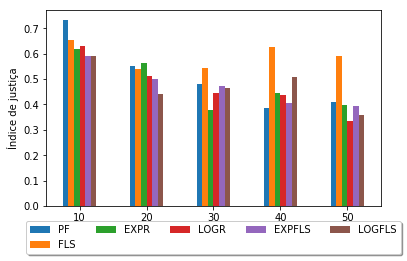

In [6]:
graphicWriter.fairnessFile(kind, True, True)

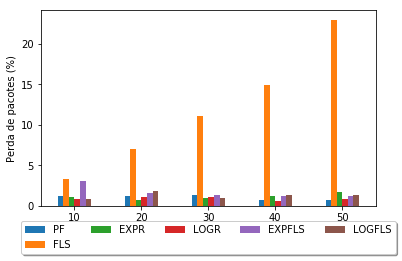

In [7]:
graphicWriter.plrFile(kind, True, True)

# CBR

In [8]:
kind = "CBR"

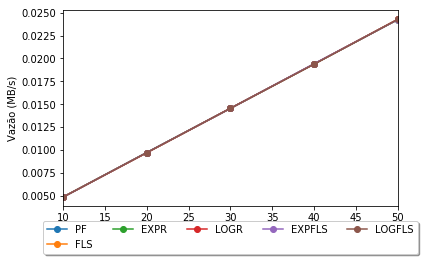

In [9]:
graphicWriter.gputFile(kind, True, True)

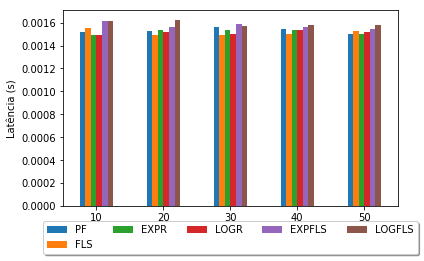

In [10]:
graphicWriter.delayFile(kind, True, True)

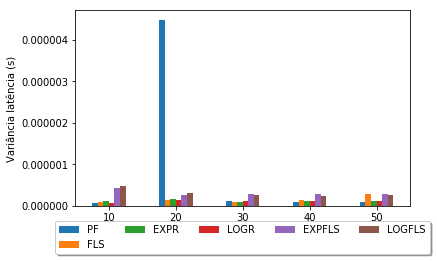

In [11]:
graphicWriter.jitterFile(kind, True, True)

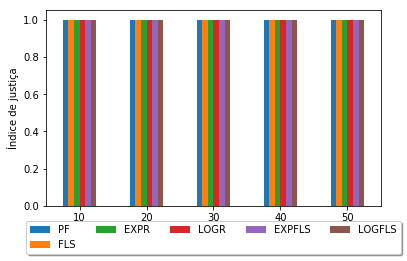

In [12]:
graphicWriter.fairnessFile(kind, True, True)

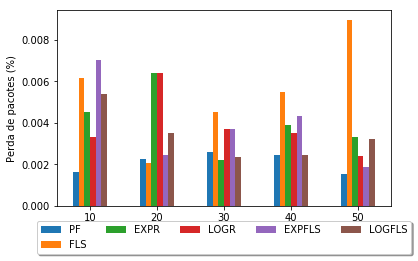

In [13]:
graphicWriter.plrFile(kind, True, True)

# Loss Ratio

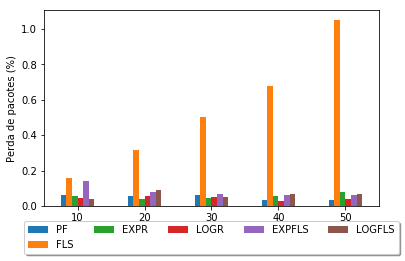

In [14]:
graphicWriter.plrGeralFile()